In [1]:
#%load_ext nb_black
%matplotlib inline
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
# Set to not show numbers with e (10 to the power of)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## This notebook aims to predict the number of new cases of COVID-19 in USA for the next 13 days.


### 1 - Visualize the time series

,NewCases
Date,
2020-04-01,25070.000
2020-04-02,30380.000
2020-04-03,31745.000
2020-04-04,33283.000
2020-04-05,28152.000


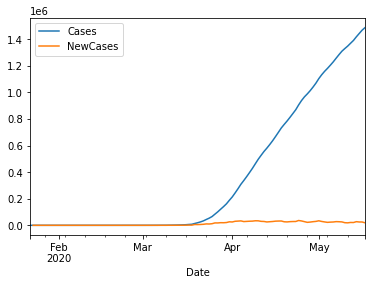

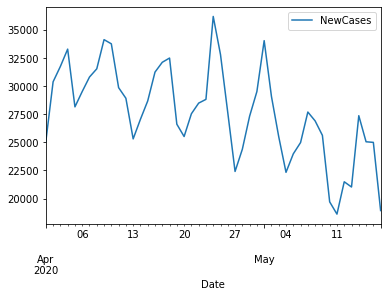

In [2]:
r = requests.get("https://covid-mgzrmsj5kq-uc.a.run.app/API/usa/timeseries/")
response_dict = r.json()
dataset = pd.DataFrame.from_dict(response_dict)
dataset = dataset.rename(columns={'Total Results as of Date': 'Date'})
dataset["Date"] = pd.to_datetime(dataset["Date"])

dataset = dataset.set_index("Date")
dataset.drop(columns=["ISO3", "Country", "Deaths", "Recovered"], inplace=True)
dataset.dropna(inplace=True)
dataset['NewCases'] = dataset['Cases'].diff()

df = dataset[dataset.Cases >= 200000]
df.drop(columns=["Cases"], inplace=True)

dataset.plot()
df.plot()
df.head()

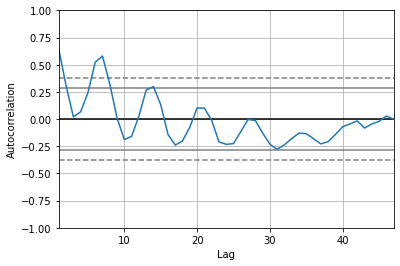

In [3]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['NewCases'])
plt.show()

<Figure size 432x288 with 0 Axes>

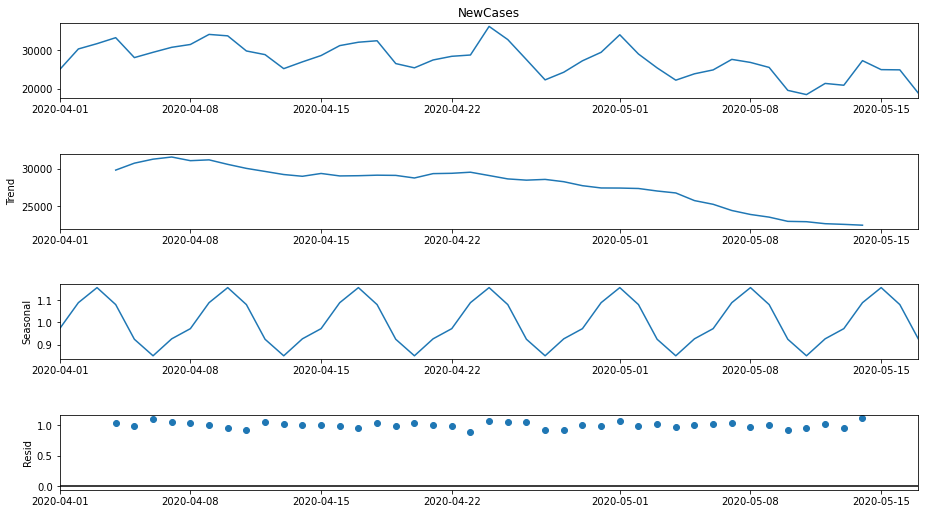

In [4]:
decomp_multiplicative = seasonal_decompose(df.NewCases, model='multiplicative')  
fig = plt.figure()  
fig = decomp_multiplicative.plot()  
fig.set_size_inches(15, 8)

df["trend"] = decomp_multiplicative.trend
df["seasonal"] = decomp_multiplicative.seasonal
df["residual"] = decomp_multiplicative.resid

### For this analysis we are gonna use the data only with more than 200000 cases.

### 2 - Stationarize the time series
A stationary (time) series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time.

We used adfuller Test to check if it is stationary.

There are various transformations that we can do to stationarize the data.

* Deflation by CPI
* Logarithmic
* First Difference
* Seasonal Difference
* Seasonal Adjustment

We used First Difference and Seasonal Difference for this analysis.



In [5]:
#Ho: It is non stationary
#H1: It is stationary
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Values:']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
def plot_adfuller_test(data):
    
    #Determing rolling statistics
    rolmean = data.rolling(window=8).mean()
    rolstd = data.rolling(window=8).std()

    #Plot rolling statistics:
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
adfuller_test(df.NewCases)

ADF Test Statistic : 0.7574711133717791
p-value : 0.9909177122311624
#Lags Used : 6
Number of Observations Used : 40
Critical Values: : {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


ADF Test Statistic : 1.5908088353958563
p-value : 0.9978297378171707
#Lags Used : 0
Number of Observations Used : 40
Critical Values: : {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


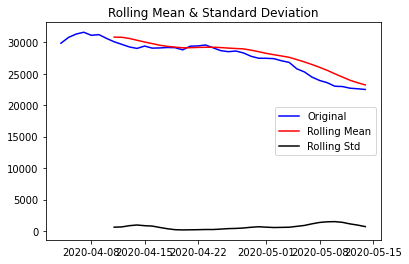

ADF Test Statistic : -2406655466876600.0
p-value : 0.0
#Lags Used : 10
Number of Observations Used : 36
Critical Values: : {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


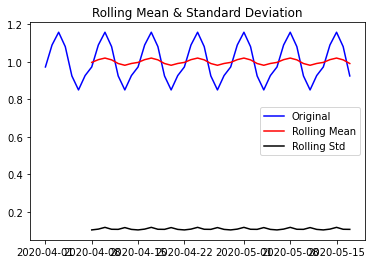

ADF Test Statistic : -5.39377248021735
p-value : 3.4907253281717104e-06
#Lags Used : 3
Number of Observations Used : 37
Critical Values: : {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


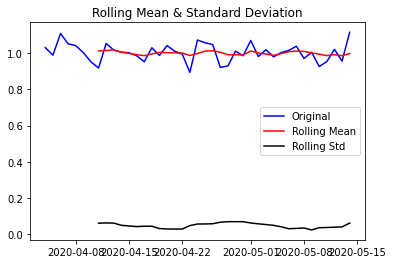

In [7]:
adfuller_test((df["trend"]).dropna())
plot_adfuller_test(df.trend)
adfuller_test((df["seasonal"]).dropna())
plot_adfuller_test(df.seasonal)
adfuller_test((df["residual"]).dropna())
plot_adfuller_test(df.residual)

ADF Test Statistic : -6.510610079883167
p-value : 1.1028341722504985e-08
#Lags Used : 5
Number of Observations Used : 40
Critical Values: : {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


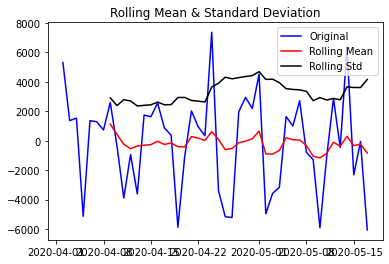

ADF Test Statistic : -3.750773203985061
p-value : 0.003453091230442664
#Lags Used : 1
Number of Observations Used : 38
Critical Values: : {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


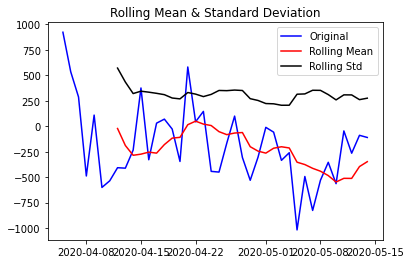

In [8]:
# Make NewCases stationary
df['Cases_FirstDiff'] = df['NewCases'].diff()
adfuller_test(df.Cases_FirstDiff.dropna(inplace=False))
plot_adfuller_test(df.Cases_FirstDiff.dropna(inplace=False))

# Make trend stationary
df['trend_FirstDiff'] = df['trend'] - df['trend'].shift(1)
adfuller_test(df.trend_FirstDiff.dropna(inplace=False))
plot_adfuller_test(df.trend_FirstDiff.dropna(inplace=False))


### 3 - ACF and PACF plots:

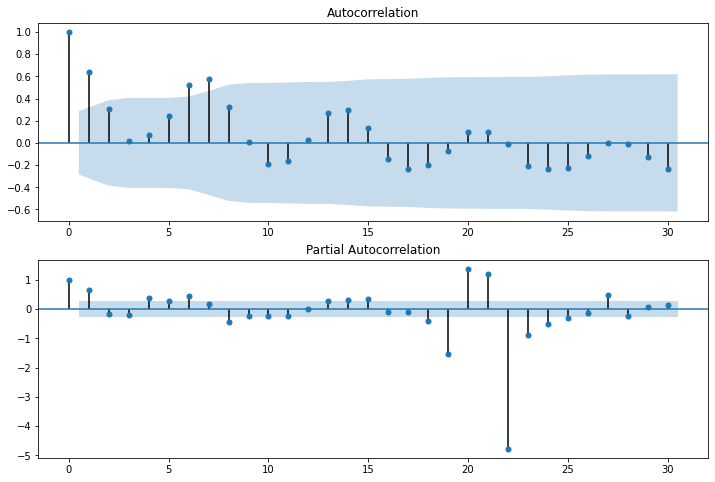

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['NewCases'],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['NewCases'],lags=30,ax=ax2)

## ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 

#### 4 - Build the ARIMA model

In [10]:
model1=ARIMA(((df['seasonal']).dropna()),order=(2,1,2))
model_fit1=model1.fit()

model2=ARIMA(((df['trend_FirstDiff']).dropna()),order=(2,0,2))
model_fit2=model2.fit()

model3=ARIMA(((df['residual']).dropna()),order=(2,0,2))
model_fit3=model3.fit()

model4=ARIMA(((df['Cases_FirstDiff']).dropna()),order=(1,1,2))
model_fit4=model4.fit()

#print(model_fit1.summary())


LinAlgError: SVD did not converge

#### 5 - Make predictions

In [ ]:
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,15)]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

In [ ]:
future_df=pd.concat([df,future_datest_df])

In [ ]:
# Model 1
# Make the prediction for the NewCasesFirstDiff
future_df['newCases_FirstDiff_forecaste'] = model_fit4.predict(start = 1, end= 115, typ="linear", dynamic= False)  

# Reverse transformation (to predict Cases) 
future_df = future_df[2:]
x, x_diff = future_df["NewCases"].iloc[0], future_df['newCases_FirstDiff_forecaste'].iloc[1:]
future_df['predicted_cases_1'] = np.r_[x, x_diff].cumsum().astype(int)
future_df[['NewCases', 'predicted_cases_1']].plot(figsize=(12, 8))

In [ ]:
# Make the prediction for the FirstDiff
future_df['trend_FirstDiff_forecaste'] = model_fit2.predict(start = 1, end= 115, typ="linear", dynamic= False)  

# Reverse the trend_FirstDiff to the original trend
future_df = future_df[2:]
x, x_diff = future_df["trend"].iloc[0], future_df['trend_FirstDiff_forecaste'].iloc[1:]
future_df['trend_forecast'] = np.r_[x, x_diff].cumsum().astype(int)
future_df[['trend', 'trend_forecast']].plot(figsize=(12, 8))

In [ ]:
future_df['seasonal_forecast'] = model_fit1.predict(start = 30, end= 115, typ="linear", dynamic= False)  
future_df[['seasonal', 'seasonal_forecast']].plot(figsize=(12, 8))

In [ ]:
future_df['residual_forecast'] = model_fit3.predict(start = 10, end= 115, dynamic= True)  
future_df[['residual', 'residual_forecast']].plot(figsize=(12, 8))

In [ ]:
# Model 2
future_df = future_df.assign(predicted_cases_2=(future_df['trend_forecast'] * future_df['residual_forecast']))

In [ ]:
# Model 3
future_df = future_df.assign(predicted_cases_3=(future_df['predicted_cases_1'] * future_df['residual_forecast']))

In [ ]:
# Model 4
future_df = future_df.assign(predicted_cases_4=((future_df['trend_forecast'] * future_df['residual_forecast'] * future_df["seasonal_forecast"]))+future_df['trend_forecast'])

In [ ]:
future_df = future_df.assign(predicted_cases_5=((future_df['trend_forecast'] * future_df['residual_forecast'] * future_df["seasonal_forecast"]))+future_df['predicted_cases_1'])

In [ ]:
future_df = future_df.assign(predicted_cases_6=((future_df['predicted_cases_1'] * future_df['residual_forecast'] * future_df["seasonal_forecast"]))+future_df['trend_forecast'])

In [ ]:
future_df[["NewCases", "predicted_cases_1", "predicted_cases_2", "predicted_cases_3", "predicted_cases_4", "predicted_cases_5", "predicted_cases_6"  ]]

In [ ]:
compare_df= future_df[["NewCases", "predicted_cases_1", "predicted_cases_2", "predicted_cases_3", "predicted_cases_4", "predicted_cases_5", "predicted_cases_6"]].dropna()
compare_df.tail(15)
compare_df.plot(figsize=(12, 8))

#### R^2

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_1)

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_2)

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_3)

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_4)

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_5)

In [ ]:
r2_score(compare_df.NewCases, compare_df.predicted_cases_6)

#### Mean Squared Error

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_1)

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_2)

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_3)

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_4)

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_5)

In [ ]:
mean_squared_error(compare_df.NewCases, compare_df.predicted_cases_6)

## Model 4 (predicted_cases_4) is the best model

In [ ]:
future_df[["NewCases", "predicted_cases_4"]]